In [1]:
using RigidBodyDynamics
using ForwardDiff
using Plots
using MeshCatMechanisms

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/20bf9867c6d8c22b253c6453b69609af00fc1eeb-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

INFO: Loading HttpServer methods...


In [136]:
# Double Pendulum
urdf = "cartpole.urdf"
cartpole = parse_urdf(Float64,urdf)
state = MechanismState(cartpole)

n = 4 # number of states
m = 2 # number of controls

# initial and goal states
x0 = [0.;pi;0.;0.]
xf = [0.;0.;0.;0.]

#set_configuration!(state, x0[1:2])
#set_velocity!(state, x0[3:4])

# costs
Q = 0.001*eye(n)
Qf = 150.0*eye(n)
R = 0.0001*eye(m)

# simulation
tf = 5.0
dt = 0.1

0.1

In [137]:
# Dynamics (RK4 discretization)
function fc(x,u)
    state = MechanismState{eltype(x)}(cartpole)
    
    # set the state variables:
    set_configuration!(state, x[1:2])
    set_velocity!(state, x[3:4])
    
    [x[3];x[4]; Array(mass_matrix(state))\u - Array(mass_matrix(state))\Array(dynamics_bias(state))]
end

function f(x,u,dt)
    # Runge-Kutta 4
    k1 = dt*fc(x,u)
    k2 = dt*fc(x + k1/2,u)
    k3 = dt*fc(x + k2/2,u)
    k4 = dt*fc(x + k3, u)
    return x + (k1 + 2*k2 + 2*k3 + k4)/6
end

function fc_aug(S)
    state = MechanismState{eltype(S)}(cartpole)
    
    # set the state variables:
    set_configuration!(state, S[1:2])
    set_velocity!(state, S[3:4])
    [S[3];S[4]; Array(mass_matrix(state))\S[5:6] - Array(mass_matrix(state))\Array(dynamics_bias(state)); 0.;0.;0.]
end

function f_aug(S)
    k1 = S[end]*fc_aug(S)
    k2 = S[end]*fc_aug(S + k1/2)
    k3 = S[end]*fc_aug(S + k2/2)
    k4 = S[end]*fc_aug(S + k3)
    return S + (k1 + 2*k2 + 2*k3 + k4)/6
end

F = S-> ForwardDiff.jacobian(f_aug, S)

(::#83) (generic function with 1 method)

In [138]:
#iLQR
function rollout(x0,U,f,dt,tf)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
      X[:,k+1] = f(X[:,k],U[:,k],dt)
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(X,U,F,Q,R,Qf,xf)
    n, N = size(X)
    m = size(U,1)
    
    S = zeros(n,n,N)
    s = zeros(n,N)
    
    Qx = zeros(n,1,N)
    Qu = zeros(m,1,N)
    Qxx = zeros(n,n,N)
    Quu = zeros(m,m,N)
    Qux = zeros(m,n,N)
    
    K = zeros(m,n,N-1)
    l = zeros(m,N-1)
    
    S[:,:,N] = Qf
    s[:,N] = Qf*(X[:,N] - xf)
    v1 = 0.0
    v2 = 0.0

    mu = 0.0
    k = N-1
    
    while k >= 1
        q = Q*(X[:,k] - xf)
        r = R*(U[:,k])
        F_aug = F([X[:,k];U[:,k];dt])
        fx = F_aug[1:size(X,1),1:size(X,1)]
        fu = F_aug[1:size(X,1),size(X,1)+1:size(X,1)+size(U,1)]
        
        Qx[:,:,k] = q + fx'*s[:,k+1]
        Qu[:,:,k] = r + fu'*s[:,k+1]
        Qxx[:,:,k] = Q + fx'*S[:,:,k+1]*fx
        Quu[:,:,k] = R + fu'*(S[:,:,k+1] + mu*eye(n))*fu
        Qux[:,:,k] = fu'*(S[:,:,k+1] + mu*eye(n))*fx

        # regularization        
        if any(x->x < 0.0, (eigvals(Quu[:,:,k])))
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end
        
        K[:,:,k] = Quu[:,:,k]\Qux[:,:,k]
        l[:,k] = Quu[:,:,k]\Qu[:,:,k]
        s[:,k] = (Qx[:,:,k]' - Qu[:,:,k]'*K[:,:,k] + l[:,k]'*Quu[:,:,k]*K[:,:,k] - l[:,k]'*Qux[:,:,k])'
        S[:,:,k] = Qxx[:,:,k] + K[:,:,k]'*Quu[:,:,k]*K[:,:,k] - K[:,:,k]'*Qux[:,:,k] - Qux[:,:,k]'*K[:,:,k]

        # terms for line search
        v1 += l[:,k]'*Qu[:,:,k]
        v2 += l[:,k]'*Quu[:,:,k]*l[:,k]
        
        k = k - 1;
    end
    return K, l, v1, v2
end

function forwardpass(X,U,f,J,K,l,v1,v2,c1=0.5,c2=.85)
    N = size(X,2)
    m = size(U,1)
    X_prev = copy(X)
    J_prev = copy(J)
    U_ = zeros(m,N-1)
    J = Inf
    dV = 0.0
    dJ = 0.0
    z = 0.0
    
    alpha = 1.0

    while J > J_prev || z < c1 || z > c2 
        for k = 1:N-1
          U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*l[:,k]
          X[:,k+1] = f(X[:,k],U_[:,k],dt);
        end

        J = cost(X,U_,Q,R,Qf,xf)
        
        dV = alpha*v1 + (alpha^2)*v2/2.0
        dJ = J_prev - J
        z = dJ/dV[1]

        alpha = alpha/2.0;
    end

    println("New cost: $J")
    println("- Expected improvement: $(dV[1])")
    println("- Actual improvement: $(dJ)")
    println("- (z = $z)\n")
    
    return X, U_, J
end

function solve(x0,m,f,F,Q,R,Qf,xf,dt,tf,iterations=50,eps=1e-3; control_init="random")
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    
    if control_init == "random"
        U = 10.0*rand(m,N-1)
    else
        U = zeros(m,N-1)
    end
        
    X = rollout(x0,U,f,dt,tf)
    J_prev = cost(X,U,Q,R,Qf,xf)
    println("Initial Cost: $J_prev\n")
    
    for i = 1:iterations
        println("*** Iteration: $i ***")
        K, l, v1, v2 = backwardpass(X,U,F,Q,R,Qf,xf)
        X, U, J = forwardpass(X,U,f,J_prev,K,l,v1,v2)

        if abs(J-J_prev) < eps
          println("-----SOLVED-----")
          println("eps criteria met at iteration: $i")
          break
        end
        J_prev = copy(J)
    end
    
    return X, U
end

solve (generic function with 3 methods)

In [139]:
X, U = @time solve(x0,m,f,F,Q,R,Qf,xf,dt,tf;control_init="random");

Initial Cost: 3574.092323608613

*** Iteration: 1 ***
New cost: 1064.5799836626902
- Expected improvement: 4466.639345467501
- Actual improvement: 2509.5123399459226
- (z = 0.5618345574492011)

*** Iteration: 2 ***
New cost: 381.8988350736591
- Expected improvement: 1329.2296432643864
- Actual improvement: 682.6811485890312
- (z = 0.5135915769320867)

*** Iteration: 3 ***
New cost: 210.61917432071388
- Expected improvement: 213.90019499460735
- Actual improvement: 171.2796607529452
- (z = 0.8007456971101095)

*** Iteration: 4 ***
New cost: 55.45018677388116
- Expected improvement: 262.70839786067023
- Actual improvement: 155.16898754683274
- (z = 0.5906510367024049)

*** Iteration: 5 ***
New cost: 13.60035077781857
- Expected improvement: 68.08229638862272
- Actual improvement: 41.84983599606259
- (z = 0.6146948357496376)

*** Iteration: 6 ***
New cost: 4.223374875295218
- Expected improvement: 15.636475493584618
- Actual improvement: 9.376975902523352
- (z = 0.5996860293977736)

*** I

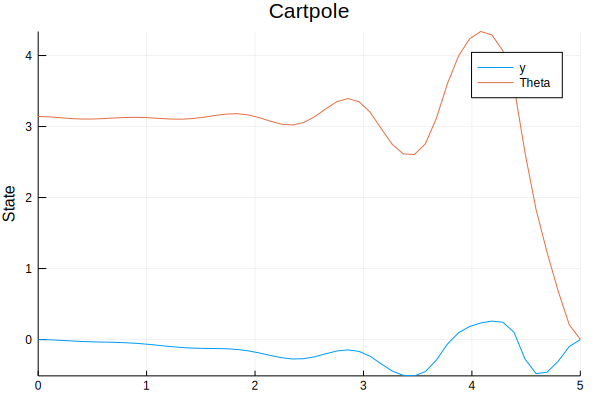

In [140]:
P = plot(linspace(0,tf,size(X,2)),X[1,:],title="Cartpole",label="y")
P = plot!(linspace(0,tf,size(X,2)),X[2,:],ylabel="State",label="\Theta")

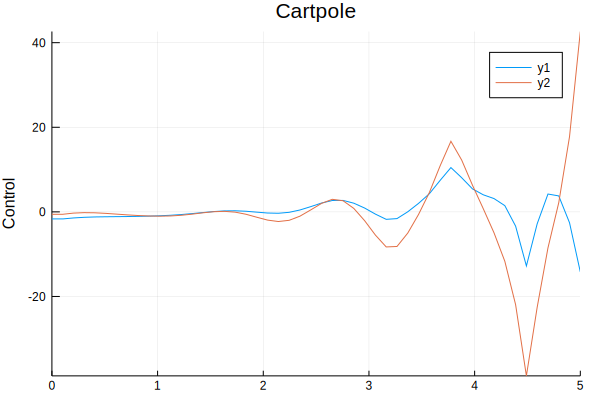

In [141]:
W = plot(linspace(0,tf,size(X,2)),[U[1,1] U[1,:]']',title="Cartpole")
W = plot!(linspace(0,tf,size(X,2)),[U[2,1] U[2,:]']',ylabel="Control")

In [142]:
vis = MechanismVisualizer(cartpole,URDFVisuals(urdf));
IJuliaCell(vis)

WebIO.Scope("scope-50a0f941-eda3-4250-8f58-572048a6d653", WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[WebIO.Node{WebIO.DOM}(WebIO.DOM(:html, :iframe), Any[], Dict{Symbol,Any}(Pair{Symbol,Any}(:attributes, Dict{String,Any}(Pair{String,Any}("height", "100%"),Pair{String,Any}("scrolling", "no"),Pair{String,Any}("src", "javascript:void(0)"),Pair{String,Any}("frameborder", 0))),Pair{Symbol,Any}(:id, "ifr"),Pair{Symbol,Any}(:style, Dict("width"=>"100%","flexGrow"=>"1"))), 0)], Dict{Symbol,Any}(Pair{Symbol,Any}(:style, Dict("flexDirection"=>"column","height"=>"100%","minHeight"=>"400px","display"=>"flex","width"=>"100%","overflow"=>"hidden"))), 1), Dict{String,Tuple{Observables.Observable,Union{Bool, Void}}}(), Set{String}(), nothing, Any[], Dict{Any,Any}(Pair{Any,Any}("_promises", Dict{Any,Any}(Pair{Any,Any}("importsLoaded", Any[WebIO.JSString("function () {\n    var frame = this.dom.querySelector(\"#ifr\");\n    var doc = frame.contentDocument\n    var win = frame.contentWindow\n\n    // Determine if we're running on a Jupyter hosting service\n    // that requires a base URL when retrieving assets\n    var curMatch =\n        window.location.href\n        .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n    curMatch = curMatch ||\n        window.location.href\n        .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n    if (curMatch) {\n        var base = doc.createElement(\"base\");\n        base.setAttribute(\"href\", curMatch[1] + '/');\n        doc.head.appendChild(base);\n    }\n\n    var webio = doc.createElement(\"script\")\n    webio.src = \"pkg/WebIO/webio/dist/bundle.js\"\n    var parent = window\n\n    function resizeIframe() {\n        doc.body.style.padding = '0'\n        doc.body.style.margin = '0'\n        doc.documentElement.height = '100%'\n        doc.body.height = '100%'\n    }\n\n    webio.onload = function () {\n        win.WebIO.sendCallback = parent.WebIO.sendCallback; // Share stuff\n        win.WebIO.scopes = parent.WebIO.scopes\n        win.WebIO.obsscopes = parent.WebIO.obsscopes\n        win.WebIO._connected = true\n        doc.body.innerHTML = \"<html><body>\" + \"<div class='display:none'></div><unsafe-script style='display:none'>\\nWebIO.mount(this.previousSibling,{&quot;props&quot;:{},&quot;nodeType&quot;:&quot;Scope&quot;,&quot;type&quot;:&quot;node&quot;,&quot;instanceArgs&quot;:{&quot;imports&quot;:{&quot;data&quot;:[{&quot;name&quot;:null,&quot;type&quot;:&quot;js&quot;,&quot;url&quot;:&quot;pkg/MeshCat/meshcat/dist/main.min.js&quot;}],&quot;type&quot;:&quot;async_block&quot;},&quot;id&quot;:&quot;scope-c0b9df78-5c2a-4988-85c1-9a69caf0cbf8&quot;,&quot;handlers&quot;:{&quot;meshcat-command&quot;:[(function (val){return this.viewer.handle_command_message({&quot;data&quot;:val})})],&quot;_promises&quot;:{&quot;importsLoaded&quot;:[(function (mc){var element=this.dom.children[0]; this.viewer=new mc.Viewer(element); WebIO.setval({&quot;name&quot;:&quot;meshcat-request&quot;,&quot;scope&quot;:&quot;scope-c0b9df78-5c2a-4988-85c1-9a69caf0cbf8&quot;,&quot;id&quot;:&quot;ob_17&quot;,&quot;type&quot;:&quot;observable&quot;},String(Date.now())); return window.document.body.style.margin=&quot;0&quot;})]}},&quot;systemjs_options&quot;:null,&quot;observables&quot;:{&quot;meshcat-command&quot;:{&quot;sync&quot;:false,&quot;id&quot;:&quot;ob_16&quot;,&quot;value&quot;:[131,166,109,97,116,114,105,120,199,64,23,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,63,164,116,121,112,101,173,115,101,116,95,116,114,97,110,115,102,111,114,109,164,112,97,116,104,218,0,33,47,109,101,115,104,99,97,116,47,119,111,114,108,100,47,115,108,105,100,101,66,97,114,47,99,97,114,116,47,112,111,108,101]},&quot;meshcat-controls&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_18&quot;,&quot;value&quot;:[]},&quot;meshcat-request&quot;:{&quot;sync&quot;:true,&quot;id&quot;:&quot;ob_17&quot;,&quot;value&quot;:&quot;&quot;}}},&quot;children&quot;:[{&quot;props&q

In [144]:
for i = 1:size(X,2)
    set_configuration!(state, X[1:2,i])
    set_configuration!(vis, configuration(state))
    sleep(dt)
end